# Week 7: Propaganda Detection

This week we will be looking at the propaganda detection task (Da San Martino 2019) and developing a baseline model for technique classification.

We will be working with an adapted version of the dataset from the paper.  In particular, I have
* reduced the number of propaganda techniques
* randomly sampled sentences labelled with a particular technique
* randomly sampled sentences (from the same original articles) which do not contain propaganda
* reformatted the data so that the snippets can be "read" in the context of the sentence by inserting \<BOS\> and \<EOS\> tags.

Let's load it up in a pandas dataframe so that we can look at some examples to illustrate that last point.

In [135]:
#mounting
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [137]:
import os
parentdir = "/Users/juliewe/Dropbox/teaching/AdvancedNLP/2024/week7/lab7/lab7resources/propaganda_dataset_v2"
train_file= "propaganda_train.tsv"
if IN_COLAB:
  parentdir = '/content/drive/MyDrive/modules/2.2/2.2-Language P-2/week7-sequence_generation/lab7resources/propaganda_dataset_v2'

train_path=os.path.join(parentdir,train_file)


In [138]:
import pandas as pd
train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
train_df.head(20)

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans..."
6,not_propaganda,A federal judge on Monday ordered U.S. immigra...
7,not_propaganda,<BOS> Kirstjen Nielsen (@SecNielsen) <EOS> Nov...
8,doubt,"As noted above, at this point literally every ..."
9,not_propaganda,Britain doesn't need more hate even just for a...


We can see in the cell above that there are 2 columns.  The first column is the label i.e., the propaganda technique or the label "not_propaganda".  The 2nd column contains the text.  Within the text we can see the special \<BOS\> and \<EOS\> tags which indicate the propaganda snippet.

Let's have a look at some examples from the **loaded_language** class.

In [139]:
train_df.columns
train_df.shape

(2560, 2)

In [140]:
train_df[train_df["label"]=="loaded_language"]

,label,tagged_in_context
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans..."
21,loaded_language,We’ve caught on to his <BOS> sneaky <EOS> syno...
49,loaded_language,This is why it is so <BOS> heinous <EOS>.”
106,loaded_language,Here is the <BOS> dirty <EOS> secret that is n...
124,loaded_language,She offered no evidence — nor was asked for an...
...,...,...
2447,loaded_language,The ADL described the video as “<BOS> venomous...
2458,loaded_language,What started after the 2016 election as a redu...
2487,loaded_language,Its superior had made the <BOS> fatal <EOS> er...
2496,loaded_language,Ridicule is a <BOS> vicious and potent <EOS> w...


In the first loaded_language example (row 5 of the original dataframe), we can see that there is a single word *annihilated* which is between \<BOS\> (**beginning of span**) and \<EOS\> (**end of span**).

### Exercise 1: Exploratory Data Analysis
Write code and plot appropriate graphs to visualise each of the following questions.

a) How many samples are there for each class?

b) What is the average length of sentence for each class?

c) What is the average length of propaganda snippet for each class?



In [141]:
train_df.shape

(2560, 2)

<ipython-input-142-99eab5fb3cec>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=label_counts, y=labels, palette=palette)


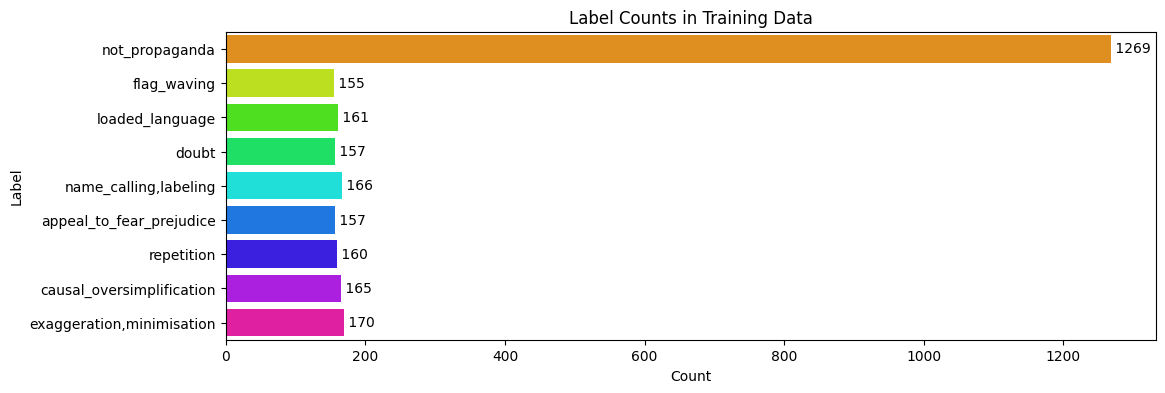

In [142]:
#a)
# train_df[train_df["label"]=="loaded_language"]

labels = train_df["label"].unique()
label_counts = [len(train_df[train_df["label"]==label]) for label in labels]


# Create a color palette with a unique color for each bar
palette = sns.color_palette("hsv", len(labels))

# Create the barplot
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed
barplot = sns.barplot(x=label_counts, y=labels, palette=palette)

# Add annotations
for index, value in enumerate(label_counts):
    plt.text(value, index, f' {value}', va='center')  # Adjust text position and formatting as needed

plt.xlabel('Count')  # Optional: customize X-axis label
plt.ylabel('Label')  # Optional: customize Y-axis label
plt.title('Label Counts in Training Data')  # Optional: add a title
plt.show()


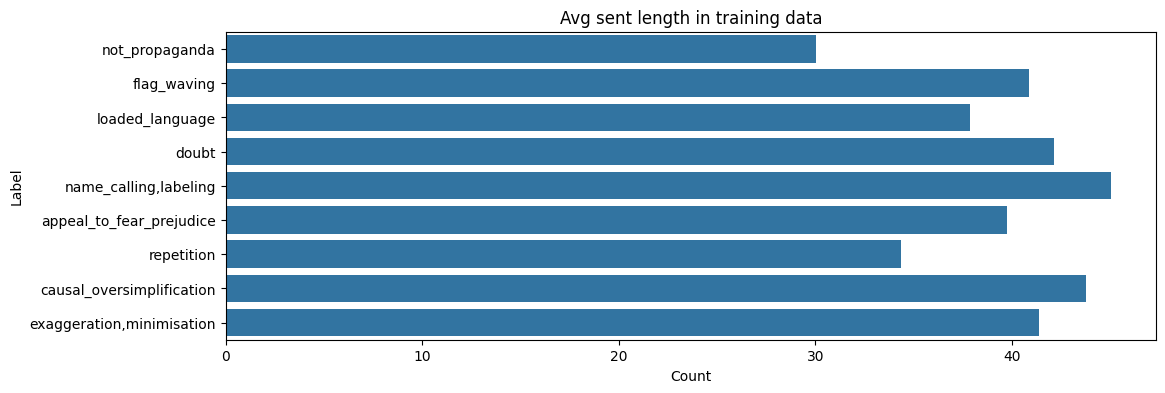

In [143]:
#b)

sents_lists = []
av_sent_lengths = []

for label in labels:
  sents_lists.append((label, train_df[train_df["label"]==label]['tagged_in_context']))

for label, sents in sents_lists:
  label_sent_total_length = sum([len(word_tokenize(sent)) for sent in sents])
  label_av_sent_len = label_sent_total_length / len(sents)
  av_sent_lengths.append((label, label_av_sent_len))

av_sent_lengths

labels, av_sent_lengths = zip(*av_sent_lengths)



# Create the barplot
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed
barplot = sns.barplot(x=av_sent_lengths, y=labels)


plt.xlabel('Count')  # Optional: customize X-axis label
plt.ylabel('Label')  # Optional: customize Y-axis label
plt.title('Avg sent length in training data')  # Optional: add a title
plt.show()


In [144]:
def get_snippet_from_sentence(single_sent):
  tokenized_sent = word_tokenize(single_sent)
  # print(tokenized_sent)
  start_idx = None
  end_idx = None
  for i, item in enumerate(tokenized_sent):
    if item == 'BOS':
      start_idx = i+2
    if item =='EOS':
      end_idx = i -1
  if start_idx is None or end_idx is None:
    raise ValueError("No BOS or EOS tags found in the sentence.")

  snippet = tokenized_sent[start_idx:end_idx]
  # print(snippet)
  # print(len(snippet))
  return snippet

def remove_tags_from_sentence(single_sent):
    tokenized_sent = word_tokenize(single_sent)

    tokenized_sent = [tokenized_sent[i] for i in range(len(tokenized_sent)) if (i == 0 or tokenized_sent[i-1] != 'BOS') and tokenized_sent[i] != 'BOS' and (i == len(tokenized_sent)-1 or tokenized_sent[i+1] != 'BOS')]
    tokenized_sent = [tokenized_sent[i] for i in range(len(tokenized_sent)) if (i == 0 or tokenized_sent[i-1] != 'EOS') and tokenized_sent[i] != 'EOS' and (i == len(tokenized_sent)-1 or tokenized_sent[i+1] != 'EOS')]

    return tokenized_sent


def get_sentences_av_snippet_len(list_of_sents):
  no_sents = len(list_of_sents)
  total_snippet_length = sum([len(get_snippet_from_sentence(single_sent)) for single_sent in list_of_sents])
  return total_snippet_length / no_sents


In [145]:
import pandas as pd

# Assuming df is your DataFrame
# Define your transformation function
def transform_strip_tag_and_tokenize(row):
    new_value = remove_tags_from_sentence(row['tagged_in_context'])
    return new_value
def transform_strip_tag(row):
    sent = row['tagged_in_context']
    cleaned_string = sent.replace("<BOS>", "")
    cleaned_string = cleaned_string.replace("<EOS>", "")
    return cleaned_string

def transform_extract_snippet(row):
    new_value = get_snippet_from_sentence(row['tagged_in_context'])
    return new_value
def transform_get_snippet_length(row):
    new_value = len(row['propaganda_snippet'])
    return new_value
def transform_get_sent_length(row):
    new_value = len(row['untagged_tokenized_sentence'])
    return new_value
def transform_binaryify(row):
    new_value = 0 if row['label'] == 'not_propaganda' else 1
    return new_value
def transform_join_snippet(row):
    new_value = row['propaganda_snippet']
    new_value = " ".join(new_value)
    print(new_value)
    return new_value


# Apply the transformation and create a new column
train_df['untagged_tokenized_sentence'] = train_df.apply(transform_strip_tag_and_tokenize, axis=1)
train_df['untagged_non_tokenized_sentence'] = train_df.apply(transform_strip_tag, axis=1)
train_df['propaganda_snippet'] = train_df.apply(transform_extract_snippet, axis=1)
train_df['snippet_len'] = train_df.apply(transform_get_snippet_length, axis=1)
train_df['sentence_len'] = train_df.apply(transform_get_sent_length, axis=1)
train_df['propaganda'] = train_df.apply(transform_binaryify, axis=1)
train_df['joined_snippet'] = train_df.apply(transform_join_snippet, axis=1)


he
won ’ t make things any worse than they are for President Trump .
American people
and
Location : Westerville , Ohio
annihilated
to argue that changing conditions in that country would make it dangerous to return ... Federal law gives authority over immigration matters to the executive
Kirstjen Nielsen ( @ SecNielsen )
so-called evidence
few days . ''
hateful conduct
likely to fail to
point to Iran ’ s positioning itself for more aggressive military actions that could place U.S. forces in harm ’ s way
Records Review Board in the 1990s , the
more
reasons of transparency , ” read a statement issued by White House
not
recount , so
But who authorized this strategic commitment
the only reason why there is general interest in the Qur ’ an among non-Muslims is to seek an answer to the question of whether or not it justifies and encourages Islamic terrorism
We must ask ourselves why this hasn ’ t happened
sneaky
America
is the point about the McCarrick scandal that even
accusations .
formall

In [146]:
train_df.head()

,label,tagged_in_context,untagged_tokenized_sentence,untagged_non_tokenized_sentence,propaganda_snippet,snippet_len,sentence_len,propaganda,joined_snippet
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.","[No, ,, he, will, not, be, confirmed, .]","No, he will not be confirmed.",[he],1,8,0,he
1,not_propaganda,This declassification effort <BOS> won’t make ...,"[This, declassification, effort, won, ’, t, ma...",This declassification effort won’t make thing...,"[won, ’, t, make, things, any, worse, than, th...",14,17,0,won ’ t make things any worse than they are fo...
2,flag_waving,"""The Obama administration misled the <BOS> Ame...","[``, The, Obama, administration, misled, the, ...","""The Obama administration misled the American...","[American, people]",2,25,1,American people
3,not_propaganda,“It looks like we’re capturing the demise of t...,"[“, It, looks, like, we, ’, re, capturing, the...",“It looks like we’re capturing the demise of t...,[and],1,43,0,and
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>","[Location, :, Westerville, ,, Ohio]","Location: Westerville, Ohio","[Location, :, Westerville, ,, Ohio]",5,5,0,"Location : Westerville , Ohio"


In [147]:
print(remove_tags_from_sentence('"The Obama administration misled the <BOS> American people <EOS> and Congress because they were desperate to get a deal with Iran," said Sen.'))

['``', 'The', 'Obama', 'administration', 'misled', 'the', 'American', 'people', 'and', 'Congress', 'because', 'they', 'were', 'desperate', 'to', 'get', 'a', 'deal', 'with', 'Iran', ',', "''", 'said', 'Sen', '.']


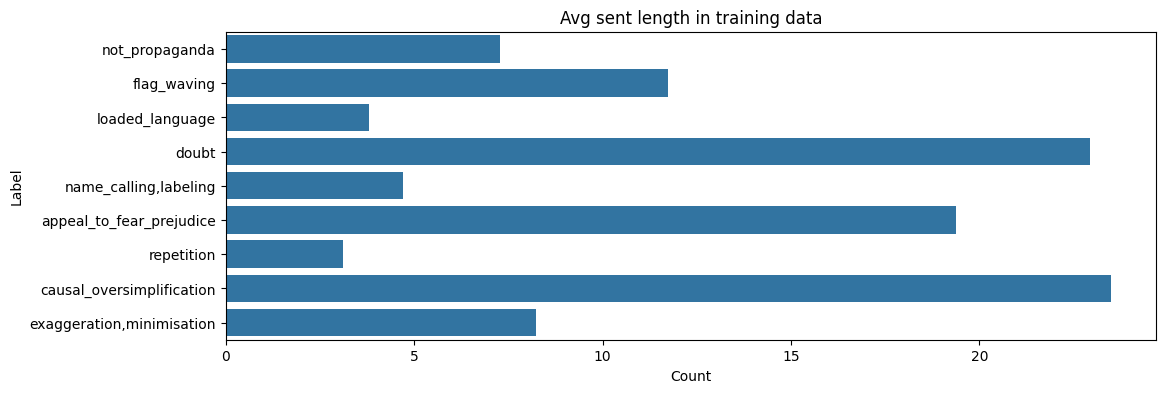

In [148]:
av_snippet_lengths = []

for label, sents in sents_lists:
  # print(label)
  label_snippets_av_length = get_sentences_av_snippet_len(sents)
  av_snippet_lengths.append((label, label_snippets_av_length))

av_snippet_lengths

labels, av_snip_lengths = zip(*av_snippet_lengths)

# Create the barplot
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed
barplot = sns.barplot(x=av_snip_lengths, y=labels)


plt.xlabel('Count')  # Optional: customize X-axis label
plt.ylabel('Label')  # Optional: customize Y-axis label
plt.title('Avg sent length in training data')  # Optional: add a title
plt.show()



### Exercise 2: Sentence Level Binary classification

Build a simple classifier (e.g., Naïve Bayes or Logistic Regression) which can take a sentence and predict whether it contains propaganda or not.  Things you will need to think about

* making a binary "propaganda" or "not_propaganda" label
* splitting the data into training and validation
* making a bag-of-words representation of each sentence.  This could be a dictionary where the keys are the words and the values are the frequencies within the sentence.  
* the implementation of the classifier itself.  You are not expected to build this yourself.  A good one to use would be the multinomialNB classifier in scikit-learn

It's worth thinking about the input format expected by the classifier before pre-processing the data.  Code to import and use the scikit-learn multinomialNB classifier is below for consideration

In [149]:
#This gives us some random toy data.
#In this toy data there are 10 data points (e.g., sentences)
# each sentence is represented as a vector of 100 values
# each value could be the frequency of a particular word in the vocab.  The max frequency here is 6
# these are stored in X
# there are 2 possible labels (0 and 1) which are stored in Y

import numpy as np
rng=np.random.RandomState()
X = rng.randint(6,size=(10,100))
Y = rng.randint(2, size=10)

print(X)
print(Y)

[[0 5 3 1 5 3 1 3 0 2 0 1 3 3 1 1 4 4 4 3 4 4 3 0 4 1 5 3 2 1 4 4 0 5 5 5
  4 4 0 0 4 3 2 4 2 1 4 3 2 1 5 5 4 2 2 4 1 4 0 0 0 1 0 3 3 5 0 5 2 0 2 5
  1 3 1 2 2 0 4 1 5 0 3 4 3 2 0 4 5 2 1 0 1 0 3 4 4 5 1 1]
 [4 4 5 1 1 1 4 5 3 5 1 1 0 5 5 0 1 0 3 2 2 0 0 4 2 3 4 2 2 3 3 0 0 2 4 3
  1 3 3 3 0 3 2 4 4 5 4 4 1 2 4 0 3 4 5 1 4 5 4 1 3 0 1 3 5 3 5 2 3 5 4 5
  3 1 0 1 3 0 5 0 3 2 4 0 5 4 2 3 1 3 4 3 1 0 3 1 3 0 0 3]
 [0 3 3 3 0 3 0 5 4 4 0 3 0 5 0 0 2 2 1 0 2 5 1 0 3 5 4 3 1 2 2 2 5 2 4 5
  3 5 0 0 2 3 1 2 2 1 2 2 4 3 3 5 0 0 1 5 5 1 5 5 1 0 2 1 5 0 0 5 4 5 2 0
  1 0 5 1 1 5 5 5 0 5 4 5 2 4 3 4 0 4 5 0 2 1 4 2 5 3 2 2]
 [3 5 3 3 4 0 0 5 4 5 1 5 3 1 0 0 1 5 5 3 1 0 1 1 5 1 0 5 1 2 2 2 2 3 4 1
  4 5 0 5 2 3 1 5 2 0 4 1 5 0 5 0 4 3 2 1 3 4 0 0 2 2 4 0 0 2 1 2 1 4 5 2
  5 4 0 2 3 5 3 4 5 3 5 0 3 4 1 1 4 1 2 1 5 5 1 4 0 4 3 1]
 [2 3 5 0 4 0 5 3 3 4 4 1 4 0 3 4 4 3 5 0 4 3 5 4 4 1 0 3 4 2 1 3 2 0 0 2
  5 0 3 1 5 2 1 5 5 1 5 0 4 0 4 0 1 1 3 4 3 3 2 4 3 5 3 4 2 2 5 5 0 5 1 0
  1 4 3 0 3 3 4 1 4 0 5 

In [150]:
#we can give this as input to the MultinomialNB classifier using the fit method
from sklearn.naive_bayes import MultinomialNB

classifier=MultinomialNB()
classifier.fit(X,Y)


MultinomialNB()

In [151]:
#we can predict the value for any datapoint
#here we are making up some more random points with random labels so I wouldn't expect particularly high accuracy!

X = rng.randint(6,size=(5,100))
Y = rng.randint(2, size=5)
print(Y)
classifier.predict(X)


[1 0 0 0 1]


array([1, 0, 1, 0, 0])

So imagine you have sentence representations and labels as follows.  We need to generate vectors for them where each column corresponds to a particular word in the vocabulary

In [152]:
toy_training_data=[({"everyone":1,"hates":1,"vectors":1},1),({"vectors":1,"are":1,"useful":1},0)]
Xdicts,Y=zip(*toy_training_data)


We could write some code to turn the Xdicts into vectors (you first need to work out what the vocab is and assign an index to each vocab item).  Or we can use scikit-learn's CountVectorizer directly on the texts.

In [153]:
toy_training_data=[("everyone hates vectors",1),("vectors are useful",0), ('end vectors now I hates vectors', 1)]
Xsents,Y=zip(*toy_training_data)

In [154]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()
vectorizer.fit(Xsents)

# Printing the identified Unique words along with their indices
print("Vocabulary: ", vectorizer.vocabulary_)

# Encode the sents
Xvectors = vectorizer.transform(Xsents)

print(Xvectors)

Vocabulary:  {'everyone': 2, 'hates': 3, 'vectors': 6, 'are': 0, 'useful': 5, 'end': 1, 'now': 4}
  (0, 2)	1
  (0, 3)	1
  (0, 6)	1
  (1, 0)	1
  (1, 5)	1
  (1, 6)	1
  (2, 1)	1
  (2, 3)	1
  (2, 4)	1
  (2, 6)	2


In [155]:
classifier=MultinomialNB()
classifier.fit(Xvectors,Y)

MultinomialNB()

In [156]:
classifier.predict(Xvectors[1])

array([0])

What happens if some new sentences have words not in the vocabulary?  We can see here that they are just ignored by the vectorization process - this is fine as they are not going to help the classifier as they are unknown

In [157]:
toy_test_data=[("everyone hates useful vectors",1),("vectors are really useful",0)]
Xsents,Y=zip(*toy_test_data)
testVectors=vectorizer.transform(Xsents)

print(testVectors)


  (0, 2)	1
  (0, 3)	1
  (0, 5)	1
  (0, 6)	1
  (1, 0)	1
  (1, 5)	1
  (1, 6)	1


In [158]:
classifier.predict(testVectors)

array([1, 0])

Lets go back to a modified version of the exercise which assumes we are going to use CountVectorizer and MultinomialNB

Build a MultinomialNB classifier which can take a sentence and predict whether it contains propaganda or not.  Things you will need to think about

* making a binary "propaganda" or "not_propaganda" label
* splitting the data into training and validation
* making a bag-of-words representation of each sentence using CountVectorizer
* Training a MultinomialNB classifier on the training data and evaluating it on the validation data

In [159]:
from sklearn.model_selection import train_test_split

binary_train_df = train_df.drop(labels='label', axis = 1)
binary_train_df.head()
binary_labels = binary_train_df['propaganda']
binary_sents = binary_train_df['untagged_non_tokenized_sentence']
X_train_sents, X_test_sents, y_train_sents, y_test_sents = train_test_split(binary_sents, binary_labels, test_size=0.2, random_state=42)


In [160]:
vectorizer_sents=CountVectorizer(stop_words='english')
vectorizer_sents.fit(X_train_sents)
vectorised_sents = vectorizer_sents.transform(X_train_sents)

In [161]:
print("Vocabulary: ", vectorizer_sents.vocabulary_)
print(len( vectorizer_sents.vocabulary_))
print(vectorised_sents.shape)

Vocabulary:  {'going': 2949, 'strong': 6428, 'action': 237, 'secure': 5980, 'election': 2239, 'systems': 6589, 'process': 5202, 'opt': 4706, 'anytime': 485, 'bon': 896, 'mueller': 4432, 'totally': 6786, 'conflicted': 1423, '17': 29, 'angry': 447, 'democrats': 1844, 'doing': 2088, 'dirty': 1988, 'work': 7346, 'disgrace': 2025, 'sic': 6129, 'usa': 7042, 'trump': 6871, 'wrote': 7383, 'approached': 535, 'congresswoman': 1437, 'anna': 454, 'eshoo': 2387, 'calif': 1016, 'allegations': 383, 'july': 3750, 'shortly': 6109, 'tapped': 6610, 'kavanaugh': 3771, 'replace': 5609, 'outgoing': 4752, 'supreme': 6531, 'court': 1602, 'justice': 3757, 'anthony': 470, 'kennedy': 3779, 'video': 7114, 'https': 3269, 'laucjertnc': 3880, 'news4sa': 4527, 'kabbfox29': 3764, 'pic': 4961, 'twitter': 6902, 'com': 1305, 'akznsp4ps8': 361, 'joe': 3712, 'galli': 2872, 'joegallinews': 3713, '11': 12, '2018': 79, 'says': 5910, 'just': 3756, 'fine': 2686, 'goldman': 2952, 'sachs': 5841, 'group': 3021, 'hospital': 3255, '

In [162]:
classifier_sents=MultinomialNB()
classifier_sents.fit(vectorised_sents,y_train_sents)

MultinomialNB()

In [163]:
vectorised_test_sents = vectorizer_sents.transform(X_test_sents)

In [164]:
y_test_sents

2156    1
1737    0
1173    0
478     0
1356    0
       ..
1242    0
856     1
1667    0
2467    0
1463    0
Name: propaganda, Length: 512, dtype: int64

In [165]:
predictions_sents = classifier_sents.predict(vectorised_test_sents)

count = 0
correct = 0

for i, val in enumerate(predictions_sents):
  count += 1
  if val == list(y_test_sents)[i]:
    correct += 1

print(f"accuracy = {correct/count}")

accuracy = 0.654296875


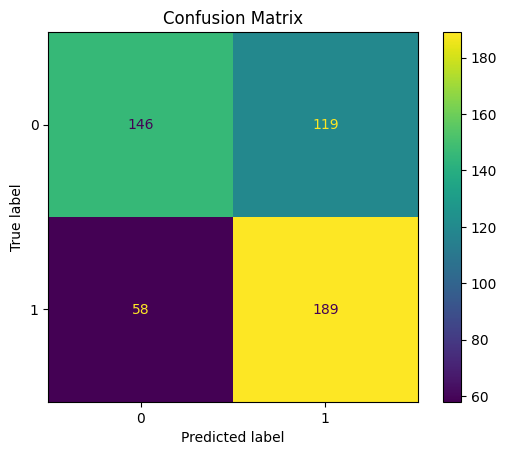

In [166]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions_sents = classifier_sents.predict(vectorised_test_sents)

# Generate confusion matrix
conf_matrix_sents = confusion_matrix(y_test_sents, predictions_sents)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_sents, display_labels=classifier_sents.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Exercise 3: Snippet level binary classification
Repeat exercise 2 but train and test on propaganda snippets rather than whole sentences.


In [167]:
binary_train_df.head()
binary_labels = binary_train_df['propaganda']
binary_snips = binary_train_df['joined_snippet']
X_train_snips, X_test_snips, y_train_snips, y_test_snips = train_test_split(binary_snips, binary_labels, test_size=0.2, random_state=42)

In [168]:
vectorizer_snips=CountVectorizer()
vectorizer_snips.fit(X_train_snips)
vectorised_snips = vectorizer_snips.transform(X_train_snips)

In [169]:
print("Vocabulary: ", vectorizer_snips.vocabulary_)
print(len( vectorizer_snips.vocabulary_))
print(vectorised_snips.shape)
classifier_snips=MultinomialNB()
classifier_snips.fit(vectorised_snips,y_train_snips)
vectorised_test_snips = vectorizer_snips.transform(X_test_snips)

Vocabulary:  {'strong': 3719, 'action': 104, 'at': 353, 'totally': 3945, 'conflicted': 802, 'to': 3928, 'replace': 3241, 'outgoing': 2749, 'supreme': 3775, 'video': 4141, 'https': 1881, 'co': 725, 'laucjertnc': 2220, 'news4sa': 2585, 'kabbfox29': 2160, 'pic': 2869, 'twitter': 4015, 'com': 736, 'akznsp4ps8': 175, 'she': 3517, 'is': 2089, 'compete': 762, 'with': 4285, 'the': 3865, 'great': 1718, 'economist': 1244, 'banning': 411, 'situation': 3574, 'first': 1545, 'responders': 3273, 'who': 4253, 'are': 297, 'headed': 1790, 'in': 1951, 'equipment': 1352, 'treason': 3971, 'were': 4236, 'targeted': 3825, 'for': 1580, 'removal': 3231, 'either': 1264, 'because': 433, 'they': 3880, 'jewish': 2125, 'or': 2716, 'he': 1788, 'had': 1751, 'that': 3864, 'written': 4322, 'down': 1200, 'and': 235, 'figured': 1525, 'out': 2745, 'so': 3596, 'would': 4312, 'know': 2192, 'where': 4245, 'shoot': 3527, 'hit': 1839, 'autonomy': 389, 'guardian': 1737, 'silently': 3558, 'edited': 1249, 'story': 3708, 'steinle'

In [170]:
predictions_snips = classifier_snips.predict(vectorised_test_snips)

count = 0
correct = 0

for i, val in enumerate(predictions_snips):
  count += 1
  if val == list(y_test_snips)[i]:
    correct += 1

print(f"accuracy = {correct/count}")

accuracy = 0.609375


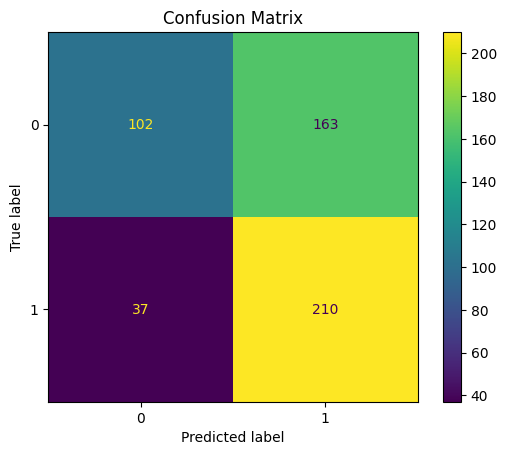

In [171]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions_snips = classifier_snips.predict(vectorised_test_snips)

# Generate confusion matrix
conf_matrix_snips = confusion_matrix(y_test_snips, predictions_snips)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_snips, display_labels=classifier_snips.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Exercise 4: Mixing snippets and sentence

* How well does your sentence level classifier work on snippets?  
* How well does snippet level classifier work on sentences?
* What about if you train on both sentences and snippets?

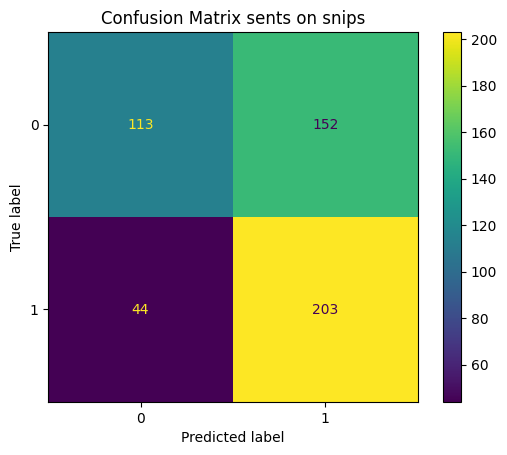

In [172]:
# sentence on snips

vectorised_snips_as_sents = vectorizer_sents.transform(X_train_snips)
vectorised_test_snips_as_sents = vectorizer_sents.transform(X_test_snips)

preds_1 = classifier_sents.predict(vectorised_test_snips_as_sents)
# Generate confusion matrix
conf_matrix_1 = confusion_matrix(y_test_snips, preds_1)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_1, display_labels=classifier_snips.classes_)
disp.plot()
plt.title('Confusion Matrix sents on snips')
plt.show()




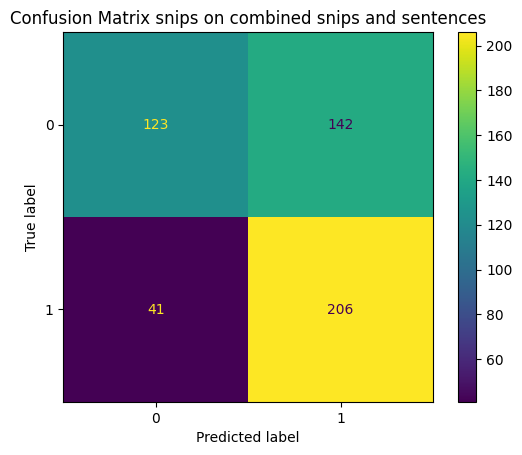

In [173]:
# snips on sentence

vectorised_sents_as_snips = vectorizer_snips.transform(X_train_sents)
vectorised_test_sents_as_snips = vectorizer_snips.transform(X_test_sents)

preds_2 = classifier_snips.predict(vectorised_test_sents_as_snips)
# Generate confusion matrix
conf_matrix_2 = confusion_matrix(y_test_sents, preds_2)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_2, display_labels=classifier_sents.classes_)
disp.plot()
plt.title('Confusion Matrix snips on combined snips and sentences')
plt.show()

In [174]:
count = 0
correct = 0

for i, val in enumerate(predictions_combined):
  count += 1
  if val == list(y_test_combined)[i]:
    correct += 1

print(f"accuracy = {correct/count}")

accuracy = 0.767578125


In [175]:
# joint

from sklearn.model_selection import train_test_split

binary_train_df = train_df.drop(labels='label', axis = 1)
binary_train_df.head()

combined_df = pd.concat([train_df['untagged_non_tokenized_sentence'], train_df['joined_snippet']])
combined_df.reset_index(drop=True, inplace=True)

combined_df
propaganda_series = pd.concat([train_df['propaganda'], train_df['propaganda']])
propaganda_series.reset_index(drop=True, inplace=True)

combined_df = pd.concat([combined_df, propaganda_series], axis=1)
combined_df.columns = ['combined_snippets_and_non_tokenized_sentence', 'propaganda']

combined_df

,combined_snippets_and_non_tokenized_sentence,propaganda
0,"No, he will not be confirmed.",0
1,This declassification effort won’t make thing...,0
2,"""The Obama administration misled the American...",1
3,“It looks like we’re capturing the demise of t...,0
4,"Location: Westerville, Ohio",0
...,...,...
5115,We support and appreciate,0
5116,capacity to check whether Iran was conducting ...,0
5117,one for those recently,0
5118,the law of gradualness not the gradualness of ...,0


In [176]:
binary_labels = combined_df['propaganda']
features = combined_df['combined_snippets_and_non_tokenized_sentence']
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(features, binary_labels, test_size=0.2, random_state=42)

vectorizer_combined=CountVectorizer()
vectorizer_combined.fit(X_train_combined)
vectorised_combined = vectorizer_combined.transform(X_train_combined)

In [177]:
classifier_combined=MultinomialNB()
classifier_combined.fit(vectorised_combined,y_train_combined)
vectorised_test_combined = vectorizer_combined.transform(X_test_combined)

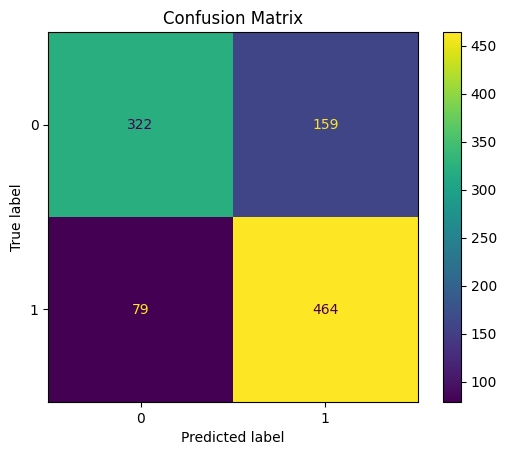

In [178]:
predictions_combined = classifier_combined.predict(vectorised_test_combined)

# Generate confusion matrix
conf_matrix_combined = confusion_matrix(y_test_combined, predictions_combined)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_combined, display_labels=classifier_combined.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [179]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_test_combined are the true labels and predictions_combined are the predictions from your classifier

# Calculate Precision for each class
precision_per_class = precision_score(y_test_combined, predictions_combined, average=None)

# Calculate Recall for each class
recall_per_class = recall_score(y_test_combined, predictions_combined, average=None)

# Calculate F1 Score for each class
f1_score_per_class = f1_score(y_test_combined, predictions_combined, average=None)

# Display the scores for each class
for i, class_label in enumerate(classifier_combined.classes_):
    print(f"Class: {class_label}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_score_per_class[i]}\n")

Class: 0
Precision: 0.8029925187032418
Recall: 0.6694386694386695
F1 Score: 0.7301587301587301

Class: 1
Precision: 0.7447833065810594
Recall: 0.85451197053407
F1 Score: 0.7958833619210979



### Extensions

1) Can you use cross-validation to evaluate your classifiers rather than a single training/development split

2) Can you use a different type of classifier and / or feature representation.  E.g., logistic regression where the feature values are tf-idf values rather than frequencies?

3) Can you carry out multi-class classification to identify the propaganda technique used?  

4) Does it help to first use your binary classifier to decide whether there is any propaganda or not?
